# 1.0 - Entrenamiento del Modelo de Diagnóstico Respiratorio

**Objetivo:** Cargar el dataset sintético, preprocesarlo, entrenar un `DecisionTreeClassifier` y guardar el modelo entrenado para su uso en producción.

## 1. Cargar Librerías y Datos

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import os

# --- Rutas ---
DATASET_PATH = '../data/processed/dataset_respiratorio.csv'
MODEL_DIR = '../models/'
MODEL_PATH = os.path.join(MODEL_DIR, 'diagnostico_dt_model.pkl')

# Crear directorio si no existe
os.makedirs(MODEL_DIR, exist_ok=True)

# Cargar datos
df = pd.read_csv(DATASET_PATH)

print("Dataset cargado exitosamente.")
print(f"Shape: {df.shape}")
df.head()

Dataset cargado exitosamente.
Shape: (1000, 14)


,fiebre,malestar_general,tos,dolor_toracico,falta_de_aire,confusion,diagnostico,gravedad,sibilancias,pecho_apretado,antecedentes_asma,edad,fumador,antecedentes_alergias
0,39.272791,True,con_flema_transparente_verdosa,molestia_leve,repentina,False,Gripe,Moderado,True,True,True,52,si_activo,False
1,39.382988,False,con_flema_purulenta_sangre,puntada_al_respirar,repentina,True,Neumonía,Grave,False,True,False,52,si_activo,False
2,37.414095,True,con_flema_transparente_verdosa,ninguno,repentina,True,Bronquitis Aguda,Leve,True,False,True,52,si_activo,True
3,37.100000,False,seca,ninguno,repentina,True,Crisis Asmática,Moderado,True,True,True,52,si_activo,True
4,37.100000,True,seca,ninguno,empeora_con_anios,False,EPOC,Moderado,False,False,True,68,de_toda_la_vida,True


## 2. Preprocesamiento de Datos

El `DecisionTreeClassifier` de scikit-learn requiere que todas las características de entrada sean numéricas. Por lo tanto, debemos convertir las columnas categóricas (como `tos` o `fumador`) a un formato numérico. Usaremos `OneHotEncoder` para esto.

In [3]:
# Separar características (X) y etiquetas (y)
# Vamos a predecir tanto el diagnóstico como la gravedad.
# En una implementación más avanzada, se podrían entrenar dos modelos separados.
X = df.drop(['diagnostico', 'gravedad'], axis=1)
y_diag = df['diagnostico']
y_grav = df['gravedad']

# Identificar columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(include=np.number).columns

print("Columnas Categóricas:", categorical_features.tolist())
print("Columnas Numéricas:", numerical_features.tolist())

Columnas Categóricas: ['malestar_general', 'tos', 'dolor_toracico', 'falta_de_aire', 'confusion', 'sibilancias', 'pecho_apretado', 'antecedentes_asma', 'fumador', 'antecedentes_alergias']
Columnas Numéricas: ['fiebre', 'edad']


In [4]:
# Crear el transformador de preprocesamiento
# OneHotEncoder para las categóricas, y 'passthrough' para las numéricas (ya están listas)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

## 3. Entrenamiento del Modelo de Árbol de Decisión

Entrenaremos un modelo para predecir el **diagnóstico**. Podríamos entrenar otro para la gravedad si fuera necesario.

In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_diag, test_size=0.2, random_state=42, stratify=y_diag)

# Crear el pipeline del modelo
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))])

# Entrenar el modelo
model_pipeline.fit(X_train, y_train)

print("Modelo entrenado exitosamente.")

Modelo entrenado exitosamente.


## 4. Evaluación del Modelo

In [6]:
# Realizar predicciones en el conjunto de prueba
y_pred = model_pipeline.predict(X_test)

# Evaluar el rendimiento
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=model_pipeline.classes_, columns=model_pipeline.classes_))

Accuracy: 1.0
Classification Report:
                  precision    recall  f1-score   support

   Bronquiolitis       1.00      1.00      1.00        28
Bronquitis Aguda       1.00      1.00      1.00        28
 Crisis Asmática       1.00      1.00      1.00        28
            EPOC       1.00      1.00      1.00        29
           Gripe       1.00      1.00      1.00        29
        Neumonía       1.00      1.00      1.00        29
   Resfrio Común       1.00      1.00      1.00        29

        accuracy                           1.00       200
       macro avg       1.00      1.00      1.00       200
    weighted avg       1.00      1.00      1.00       200

Confusion Matrix:
                  Bronquiolitis  Bronquitis Aguda  Crisis Asmática  EPOC  \
Bronquiolitis                28                 0                0     0   
Bronquitis Aguda              0                28                0     0   
Crisis Asmática               0                 0               28     0   


## 5. Guardar el Modelo Entrenado

Finalmente, guardamos el pipeline completo (preprocesador + clasificador) en un archivo `.pkl` para que pueda ser cargado y utilizado por nuestra aplicación Flask.

In [7]:
# Guardar el pipeline del modelo
joblib.dump(model_pipeline, MODEL_PATH)

print(f"Modelo guardado en: {MODEL_PATH}")

Modelo guardado en: ../models/diagnostico_dt_model.pkl


## 6. Visualización del Árbol de Decisión

Para entender cómo el modelo toma sus decisiones, vamos a visualizar la estructura del árbol de decisión. Esto nos ayudará a identificar qué características (síntomas) son más importantes y cómo el modelo clasifica los diferentes diagnósticos.

Árbol de decisión guardado como imagen en: ../reports/figures\decision_tree.png


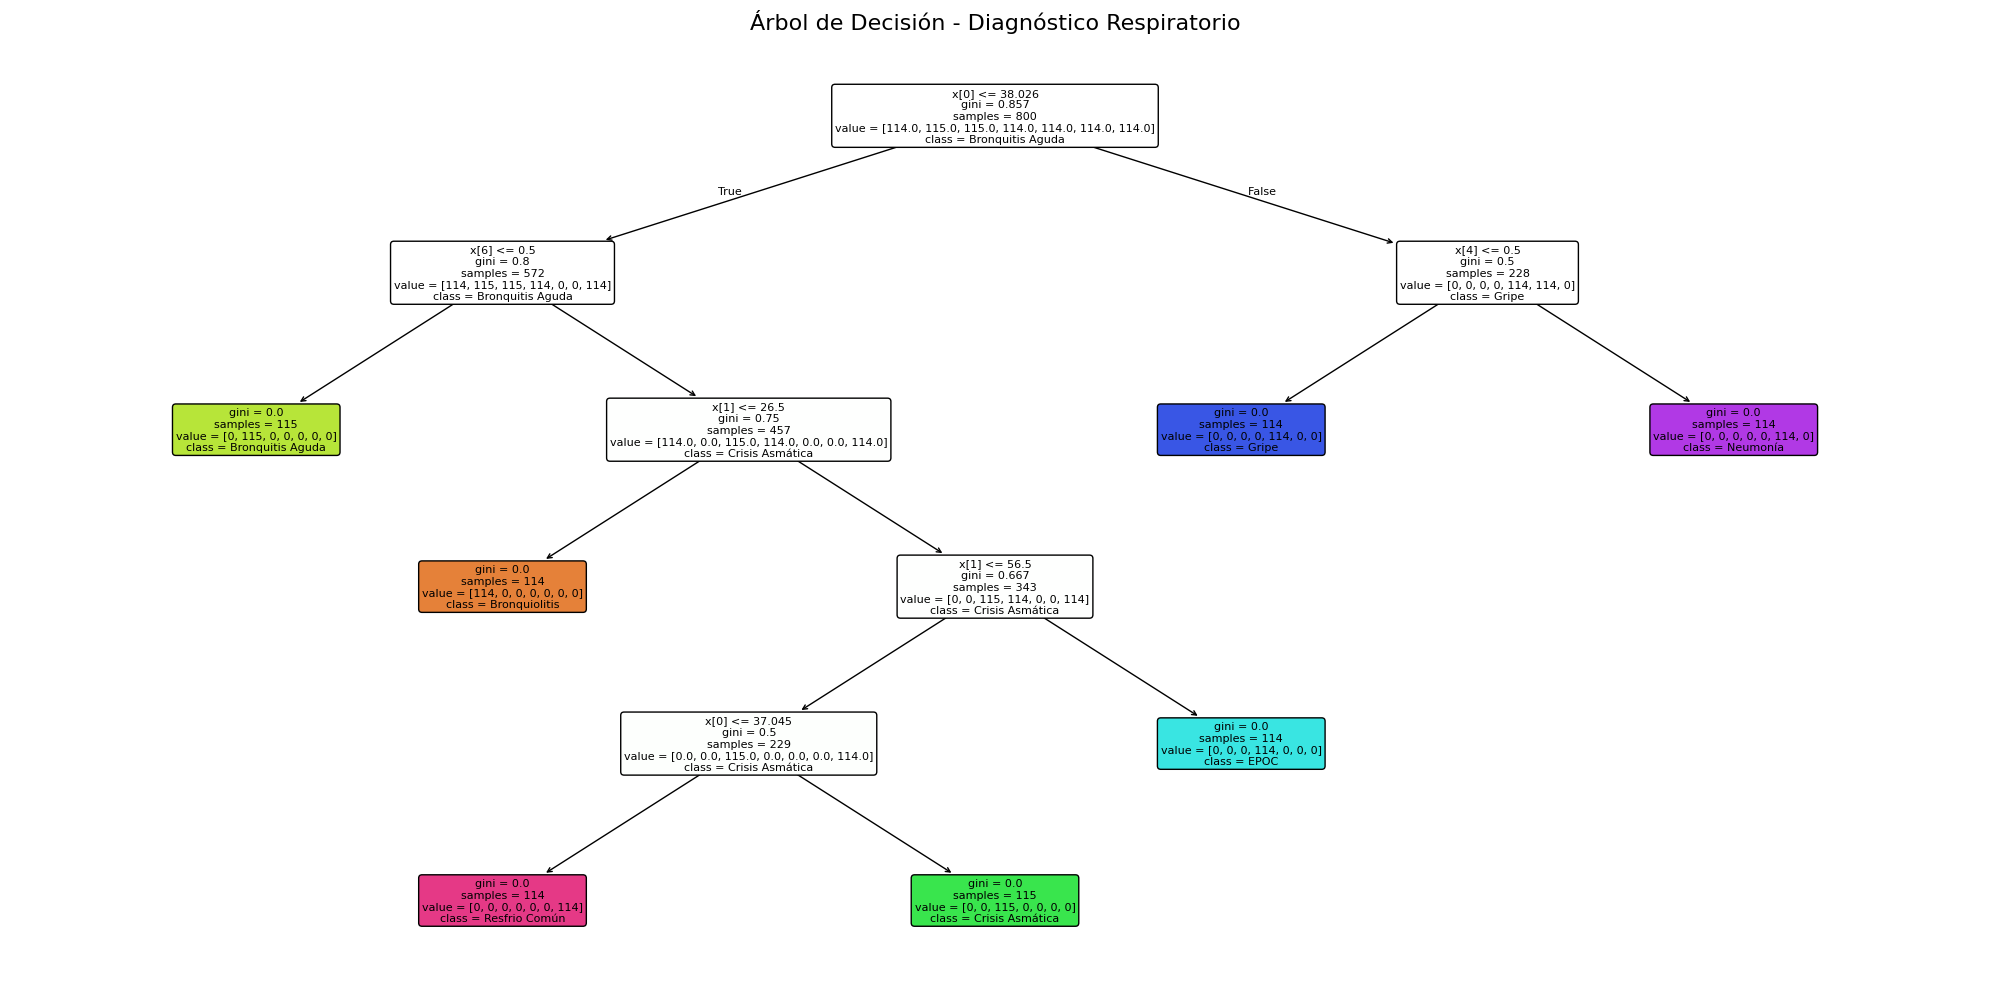


Importancia de las características:
Característica 0: 0.333
Característica 1: 0.333
Característica 4: 0.166
Característica 6: 0.167


In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Crear directorio para guardar la imagen
reports_dir = '../reports/figures'
os.makedirs(reports_dir, exist_ok=True)

# Obtener el clasificador del pipeline
tree_classifier = model_pipeline.named_steps['classifier']

# Crear una figura grande para el árbol
plt.figure(figsize=(20, 10))

# Visualizar el árbol de decisión
plot_tree(tree_classifier, 
          feature_names=None,  # Usaremos nombres simplificados
          class_names=tree_classifier.classes_,
          filled=True,
          rounded=True,
          fontsize=8)

plt.title("Árbol de Decisión - Diagnóstico Respiratorio", fontsize=16)
plt.tight_layout()

# Guardar la imagen
tree_image_path = os.path.join(reports_dir, 'decision_tree.png')
plt.savefig(tree_image_path, dpi=300, bbox_inches='tight')

print(f"Árbol de decisión guardado como imagen en: {tree_image_path}")

# Mostrar el árbol en el notebook
plt.show()

# Mostrar la importancia de las características
feature_importance = tree_classifier.feature_importances_
print("\nImportancia de las características:")
for i, importance in enumerate(feature_importance):
    if importance > 0.01:  # Solo mostrar características importantes
        print(f"Característica {i}: {importance:.3f}")